# Met-Encefalina

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app
import molmodmt as molmodmt
import openmmtools as mmtools
from pdbfixer import PDBFixer
import mdtraj as md
import nglview as nv
from sys import stdout

In [2]:
plt.style.use('ggplot')

## Definición del sistema

### Campo de fuerzas

In [3]:
forcefield = app.ForceField('amber99sbildn.xml', 'tip3p.xml')

### Trabajando el PDB original

Hacemos uso en primer lugar de la librería `pdbfixer` para trabajar desde el pdb antes de nada.

In [4]:
system_pdb=PDBFixer(pdbid='1PLX')

In [5]:
system_pdb.topology

<Topology; 1 chains, 5 residues, 75 atoms, 76 bonds>

In [6]:
for chain in system_pdb.topology.chains():
    print("Chain index {} with pdb id {}:".format(chain.id,chain.index))
    for residue in chain.residues():
        print("\t Residue name {}, index {}:".format(residue.name, residue.index))
        for atom in residue.atoms():
            print("\t \t Atom name {}, index {}".format(atom.name, atom.index))

Chain index A with pdb id 0:
	 Residue name TYR, index 0:
	 	 Atom name N, index 0
	 	 Atom name CA, index 1
	 	 Atom name C, index 2
	 	 Atom name O, index 3
	 	 Atom name CB, index 4
	 	 Atom name CG, index 5
	 	 Atom name CD1, index 6
	 	 Atom name CD2, index 7
	 	 Atom name CE1, index 8
	 	 Atom name CE2, index 9
	 	 Atom name CZ, index 10
	 	 Atom name OH, index 11
	 	 Atom name H, index 12
	 	 Atom name H2, index 13
	 	 Atom name H3, index 14
	 	 Atom name HA, index 15
	 	 Atom name HB2, index 16
	 	 Atom name HB3, index 17
	 	 Atom name HD1, index 18
	 	 Atom name HD2, index 19
	 	 Atom name HE1, index 20
	 	 Atom name HE2, index 21
	 	 Atom name HH, index 22
	 Residue name GLY, index 1:
	 	 Atom name N, index 23
	 	 Atom name CA, index 24
	 	 Atom name C, index 25
	 	 Atom name O, index 26
	 	 Atom name H, index 27
	 	 Atom name HA2, index 28
	 	 Atom name HA3, index 29
	 Residue name GLY, index 2:
	 	 Atom name N, index 30
	 	 Atom name CA, index 31
	 	 Atom name C, index 32
	

Es posible que el pdb carezca de algunos residuos o átomos puntuales.

In [7]:
missing_residues     = system_pdb.findMissingResidues()
nonstandard_residues = system_pdb.findNonstandardResidues()
missing_atoms        = system_pdb.findMissingAtoms()

print('Missing residues:')
print(missing_residues)
print('NonStandard residues:')
print(nonstandard_residues)
print('Missing atoms:')
print(missing_atoms)

Missing residues:
None
NonStandard residues:
None
Missing atoms:
None


En caso de encontrar residues no estandard, los podríamos reemplazar con el comando:

In [8]:
system_pdb.replaceNonstandardResidues()

En este caso no hay falta de átomos o residuos. Si lo hubiera, PDBFix puede añadirlos con el comando:

In [9]:
system_pdb.addMissingAtoms()

PDBFix puede añadir hidrógenos según pH y solvatar, como se muestra en la siguiente celda. Pero como se recomienda en la documentación de OpenMM lo vamos a hacer con Modeller. Hay que revisar el flujo de trabajo de YANK para ver como protona, solvata e ioniza.

In [10]:
if False: # Celda sólo para muestra, no para ejecutar
    system_pdb.addMissingHydrogens(pH=7.4)
    system_pdb.addSolvent(Vec3(5, 5, 5)*nanometer, positiveIon='Na+', negativeIon='Cl-', ionicStrength=0.1*molar)

Antes de solvatar y crear el sistema que simularemos con OpenMM, veamos lo que hasta ahora tenemos:

In [11]:
system_topology_md = md.Topology.from_openmm(system_pdb.topology)
system_md = md.Trajectory(system_pdb.positions/unit.nanometer,system_topology_md)
view=nv.show_mdtraj(system_md)
view.clear()
view.add_ball_and_stick("protein")
view

NGLWidget()

O podríamos de nuevo haber recurrido a MolModMT:

In [12]:
view=molmodmt.view(system_pdb)
view.clear()
view.add_ball_and_stick("protein")
view

NGLWidget()

In [13]:
view.render_image() # Para que la imagen pueda ser mostrada en la versión del notebook de GitHub

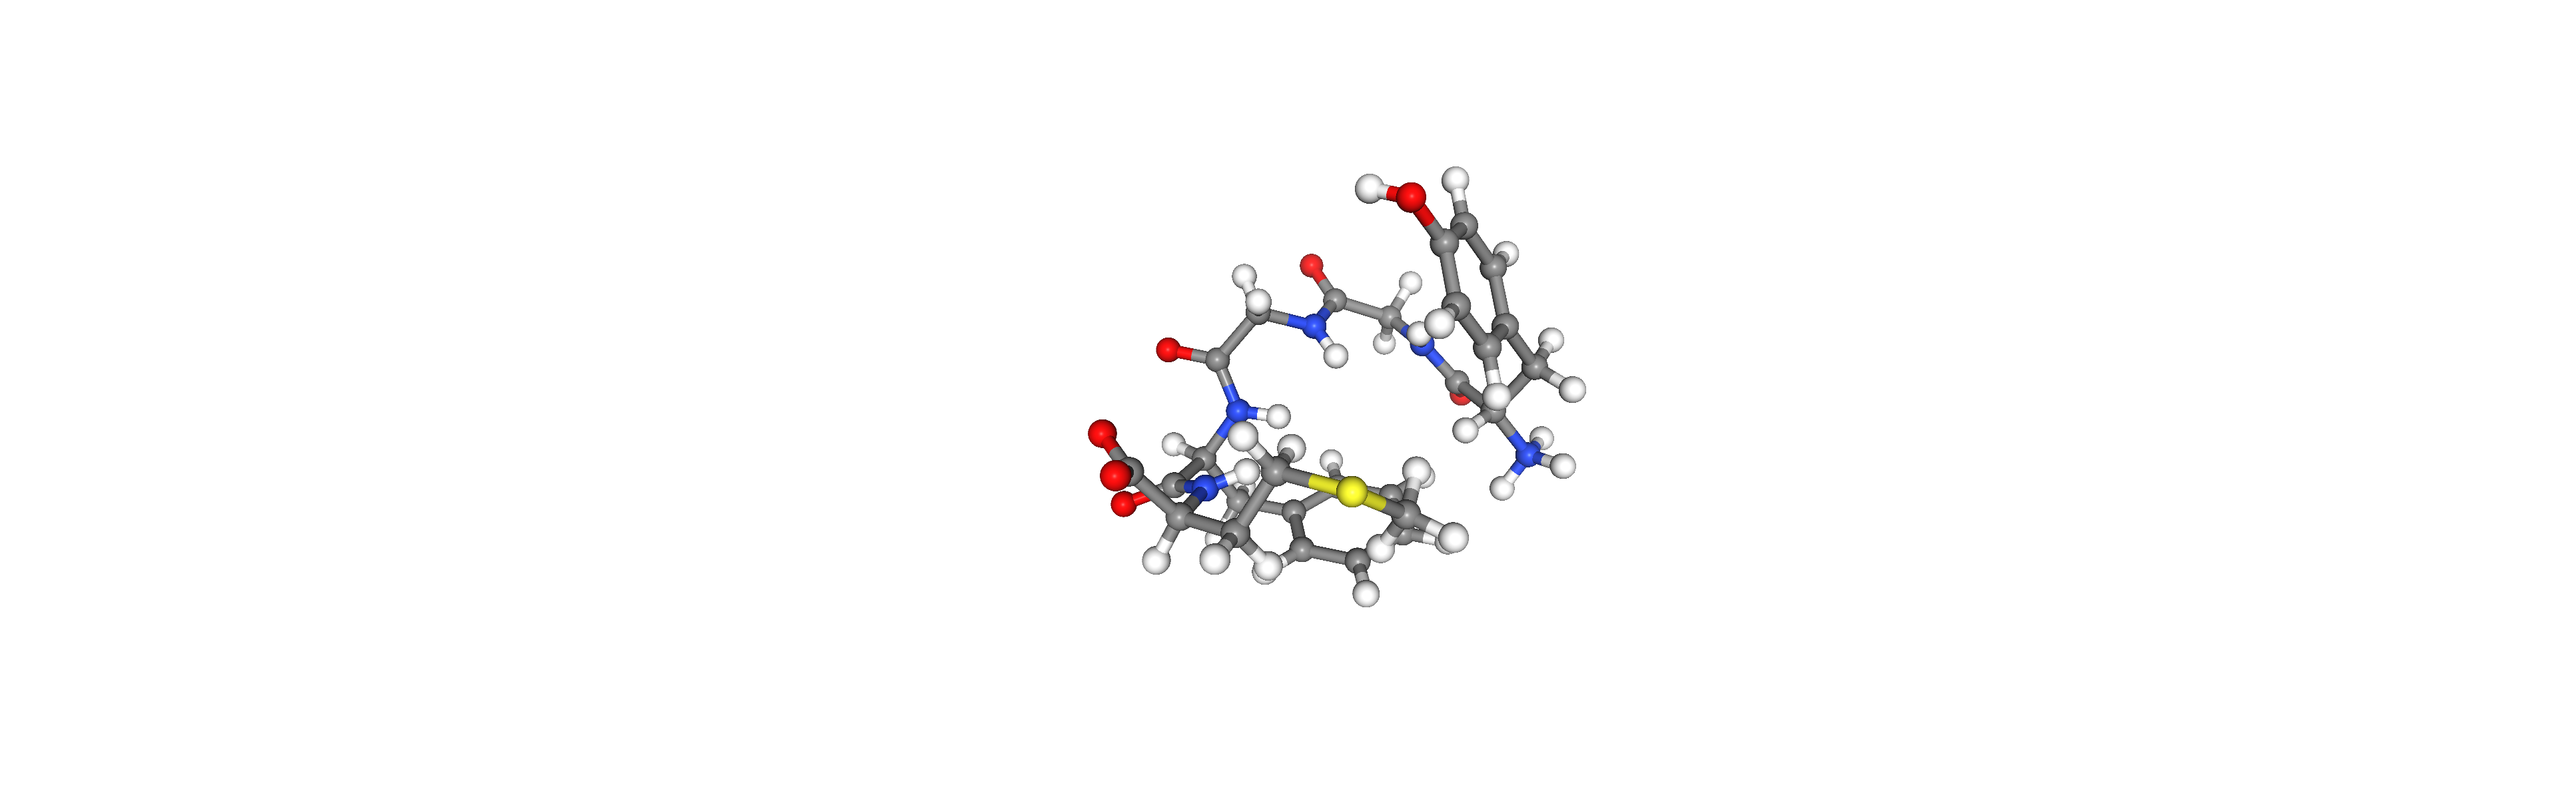

In [14]:
view._display_image() # Para que la imagen pueda ser mostrada en la versión del notebook de GitHub

En el caso de que hubíeramos modificado el pdb original descargado directamente del Protein Data Bank, podemos escribir nuestra nueva versión del fichero:

In [15]:
app.PDBFile.writeFile(system_pdb.topology, system_pdb.positions, open('metenkephalin_fixed.pdb', 'w'))

O si no recordamos la sintaxis concreta que usa `openmm` para escribir ficheros pdb, podemos acudir a la librería MolModMT para que haga el trabajo por nosotros:

In [16]:
molmodmt.write(system_pdb,'metenkephalin_fixed.pdb')

Ya puedes echarle un vistazo al fichero recien creado. Las celdas de jupyter interpretan ciertos comandos básicos del bash.

In [17]:
### Descomenta la siguiente linea para ver el contenido del fichero
!cat metenkephalin_fixed.pdb

REMARK   1 CREATED WITH OPENMM 7.3, 2019-01-07
CRYST1    1.000    1.000    1.000  90.00  90.00  90.00 P 1           1 
ATOM      1  N   TYR A   1       1.195   3.926   2.552  1.00  0.00           N  
ATOM      2  CA  TYR A   1       0.509   3.483   1.309  1.00  0.00           C  
ATOM      3  C   TYR A   1       1.466   3.480   0.121  1.00  0.00           C  
ATOM      4  O   TYR A   1       2.626   3.875   0.242  1.00  0.00           O  
ATOM      5  CB  TYR A   1      -0.662   4.428   1.036  1.00  0.00           C  
ATOM      6  CG  TYR A   1      -1.698   3.859   0.092  1.00  0.00           C  
ATOM      7  CD1 TYR A   1      -2.555   2.843   0.497  1.00  0.00           C  
ATOM      8  CD2 TYR A   1      -1.814   4.337  -1.206  1.00  0.00           C  
ATOM      9  CE1 TYR A   1      -3.499   2.321  -0.366  1.00  0.00           C  
ATOM     10  CE2 TYR A   1      -2.755   3.820  -2.076  1.00  0.00           C  
ATOM     11  CZ  TYR A   1      -3.595   2.812  -1.651  1.00  0.00     

### Creamos la caja y solvatamos

Podemos crear la caja y solvatar directamente con PDBFixer o con otras herramientas. Pero lo vamos a hacer con otra herramienta muy util también del flujo de trabajo propuesto por OpenMM, `modeller`, para ir conociendola:

In [18]:
system_modeller = app.Modeller(system_pdb.topology, system_pdb.positions)

De nuevo, si no recordamos la sintaxis específica de creación del objeto `Modeller` desde un sistema de `openmm` o `pdbfixer` podemos acudir a MolModMT:

In [19]:
system_modeller = molmodmt.convert(system_pdb,'modeller')

In [20]:
system_modeller.addHydrogens(forcefield,pH=7.4)

[None, None, None, None, None]

In [21]:
system_modeller.addSolvent(forcefield, model='tip3p', padding=1.4*unit.nanometers,
                           positiveIon='Na+', negativeIon='Cl-', ionicStrength=0.1*unit.molar)

Podemos si queremos, escribir un nuevo pdb del sistema la caja solvatada.

In [22]:
molmodmt.write(system_modeller,'metenkephalin_solvated.pdb')

In [23]:
### Descomenta la siguiente linea para ver el contenido del fichero
#!cat metenkephalin_solvated.pdb

REMARK   1 CREATED WITH OPENMM 7.3, 2019-01-07
CRYST1   38.658   38.658   38.658  90.00  90.00  90.00 P 1           1 
ATOM      1  N   TYR A   1       1.195   3.926   2.552  1.00  0.00           N  
ATOM      2  CA  TYR A   1       0.509   3.483   1.309  1.00  0.00           C  
ATOM      3  C   TYR A   1       1.466   3.480   0.121  1.00  0.00           C  
ATOM      4  O   TYR A   1       2.626   3.875   0.242  1.00  0.00           O  
ATOM      5  CB  TYR A   1      -0.662   4.428   1.036  1.00  0.00           C  
ATOM      6  CG  TYR A   1      -1.698   3.859   0.092  1.00  0.00           C  
ATOM      7  CD1 TYR A   1      -2.555   2.843   0.497  1.00  0.00           C  
ATOM      8  CD2 TYR A   1      -1.814   4.337  -1.206  1.00  0.00           C  
ATOM      9  CE1 TYR A   1      -3.499   2.321  -0.366  1.00  0.00           C  
ATOM     10  CE2 TYR A   1      -2.755   3.820  -2.076  1.00  0.00           C  
ATOM     11  CZ  TYR A   1      -3.595   2.812  -1.651  1.00  0.00     

HETATM 5254  H2  HOH B1730      10.255   3.835  19.294  1.00  0.00           H  
HETATM 5255  O   HOH B1731      14.194 -16.636  11.789  1.00  0.00           O  
HETATM 5256  H1  HOH B1731      13.557 -16.178  11.240  1.00  0.00           H  
HETATM 5257  H2  HOH B1731      13.667 -17.222  12.331  1.00  0.00           H  
HETATM 5258  O   HOH B1732      13.102   1.885  10.788  1.00  0.00           O  
HETATM 5259  H1  HOH B1732      12.261   2.343  10.797  1.00  0.00           H  
HETATM 5260  H2  HOH B1732      13.288   1.745   9.859  1.00  0.00           H  
HETATM 5261  O   HOH B1733      11.267 -13.059  11.158  1.00  0.00           O  
HETATM 5262  H1  HOH B1733      11.596 -12.605  10.382  1.00  0.00           H  
HETATM 5263  H2  HOH B1733      12.011 -13.078  11.759  1.00  0.00           H  
HETATM 5264  O   HOH B1734      16.277  17.693 -11.046  1.00  0.00           O  
HETATM 5265  H1  HOH B1734      15.812  16.896 -11.299  1.00  0.00           H  
HETATM 5266  H2  HOH B1734  

Podemos también visualizar el nuevo sistema

In [24]:
view_solvated=molmodmt.view(system_modeller)
view_solvated.clear()
view_solvated.add_ball_and_stick("protein")
view_solvated.add_ball_and_stick("ion", radiusSize=0.2)
view_solvated.add_surface("all", color="cyan", opacity=0.1)
view_solvated.center()
view_solvated

NGLWidget()

In [25]:
view_solvated.render_image() # Para que la imagen pueda ser mostrada en la versión del notebook de GitHub

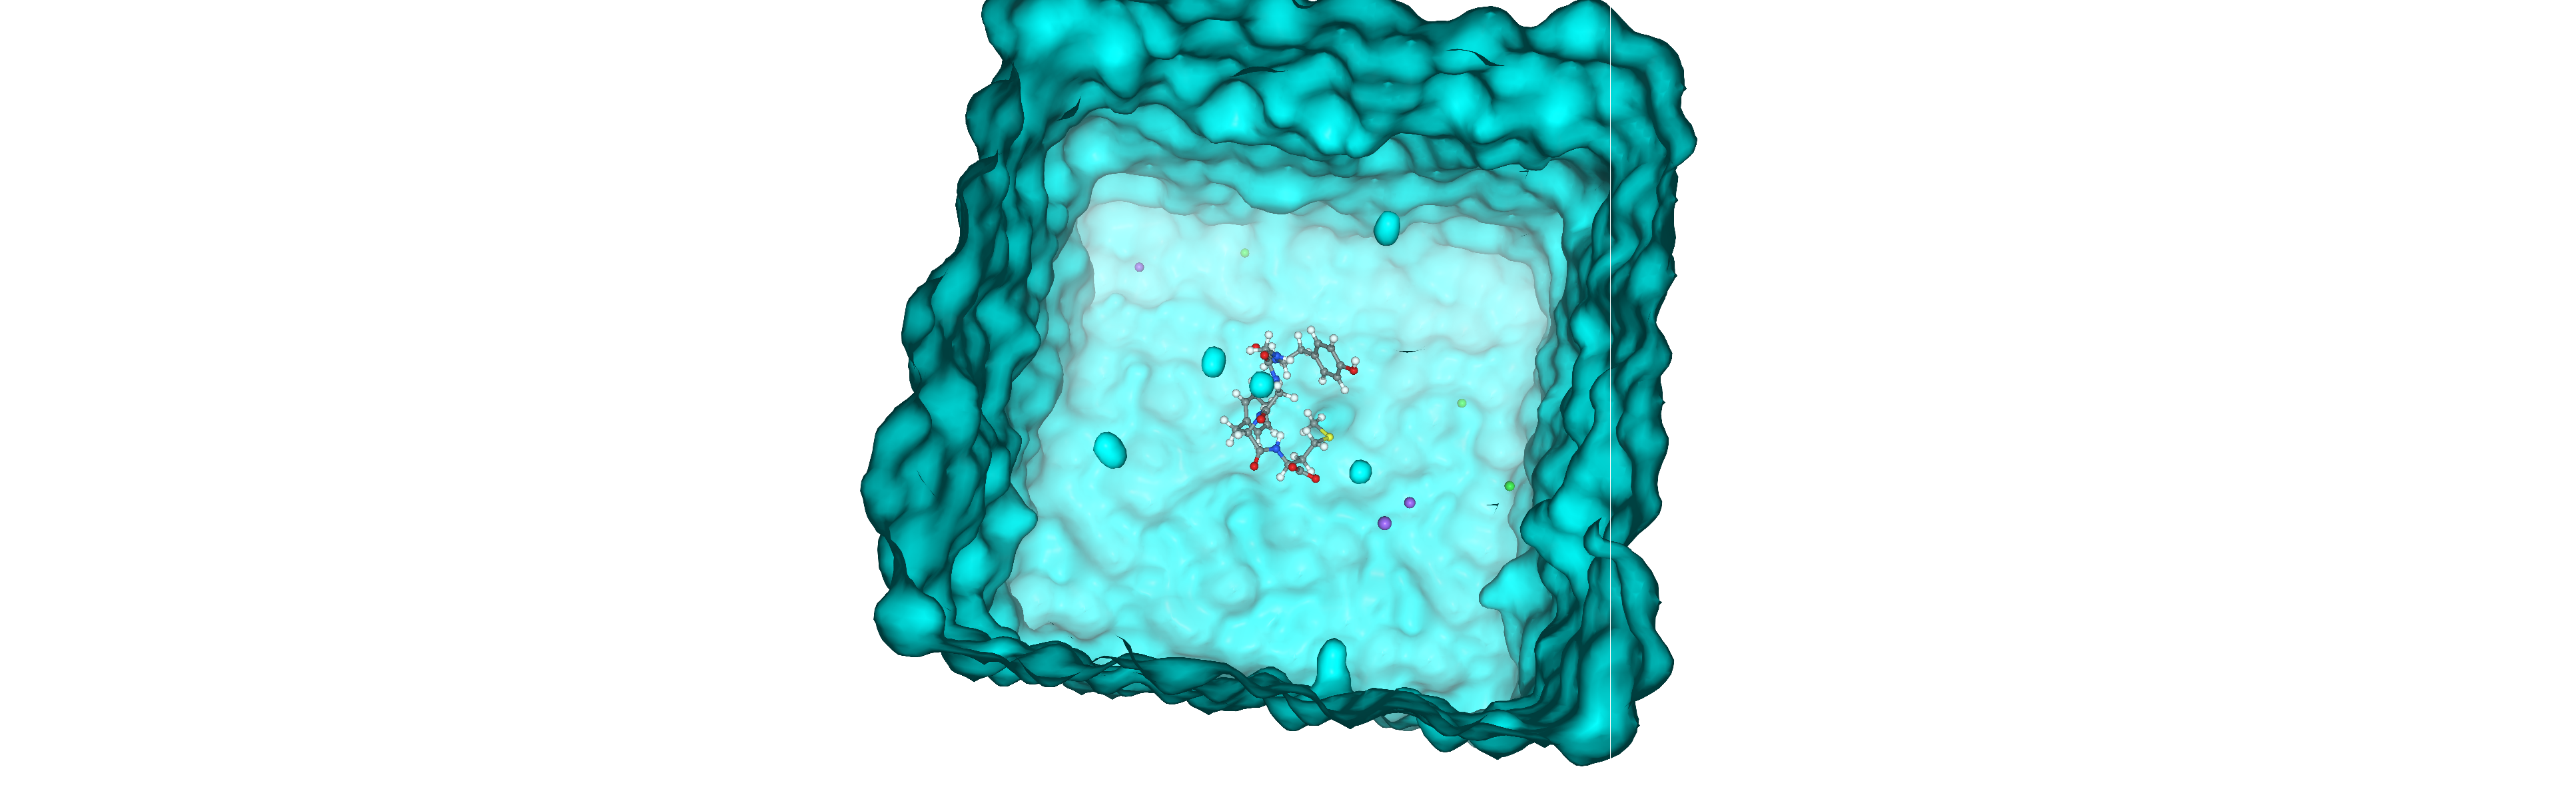

In [26]:
view_solvated._display_image() # Para que la imagen pueda ser mostrada en la versión del notebook de GitHub

Por último creamos el sistema molecular que integraremos haciendo uso de la topología creada con modeller. Las posiciones las recuperaremos mas adelante como condición inicial.

In [27]:
system = forcefield.createSystem(system_modeller.topology,
                                 nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometers,
                                 constraints=app.HBonds, rigidWater=True, ewaldErrorTolerance=0.0005)

# Estado termodinámico

In [28]:
# Formalismo NVT
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300*unit.kelvin
pressure    = None

# Integrador

In [29]:
friction   = 1.0/unit.picosecond
step_size  = 2.0*unit.femtoseconds
integrator = mm.LangevinIntegrator(temperature, friction, step_size)
integrator.setConstraintTolerance(0.00001)

# Parámetros de la simulación

In [30]:
simulation_time = 0.5*unit.nanoseconds
saving_time     = 0.5*unit.picoseconds

simulation_steps = round(simulation_time/step_size)
saving_steps     = round(saving_time/step_size)
num_steps_saved  = round(simulation_steps/saving_steps)

# Plataforma de simulación

En la computadora tengo una tarjeta gráfica controlada por un driver de Nvidia. Siendo este el caso, y teniendo cuda instalado (`conda install cudatoolkit`), OpenMM detecta CUDA como plataforma para calcular:

In [31]:
for ii in range(mm.Platform.getNumPlatforms()):
    platform_name  = mm.Platform.getPlatform(ii).getName()
    platform       = mm.Platform.getPlatformByName(platform_name)
    platform_speed = platform.getSpeed()
    print('Plataforma {} con velocidad {}'.format(platform_name,platform_speed))
    del(platform_name, platform, platform_speed)

Plataforma Reference con velocidad 1.0
Plataforma CPU con velocidad 10.0
Plataforma CUDA con velocidad 100.0
Plataforma OpenCL con velocidad 50.0


En el caso de que no aparezca CUDA en tu listado, es posible que o no tengas cudatoolkit instalado o tu entorno de conda no vea las librerías. Puedes probar a identificar el problema con la siguiente celda:

In [32]:
print(mm.Platform.getPluginLoadFailures())

()


Si el error es parecido a algo como:

>('Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMCUDA.so: libcufft.so.9.2: cannot open shared object file: No such file or directory', 'Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMRPMDCUDA.so: libOpenMMCUDA.so: cannot open shared object file: No such file or directory', 'Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMDrudeCUDA.so: libOpenMMCUDA.so: cannot open shared object file: No such file or directory', 'Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMAmoebaCUDA.so: libOpenMMCUDA.so: cannot open shared object file: No such file or directory', 'Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMCudaCompiler.so: libnvrtc.so.9.2: cannot open shared object file: No such file or directory')

entonces es que no está instalado CUDA. Échale un ojo al [notebook dedicado a este tema](../Introducción/CUDA.ipynb).

Selecciono la plataforma CUDA para simulación:

In [33]:
platform = mm.Platform.getPlatformByName('CUDA')
properties = {'CudaPrecision': 'mixed'}

## Simulación

Existe un objeto en OpenMM llamado `app.Simulation` que encapsula atributos y métodos propios de la simulación. Anteriormente habíamos creado nosotros el contexto de la siguiente manera:

In [ ]:
# context = mm.Context(system.system, integrator, platform)

Y con ese contexto integrábamos la dinámica y extraíamos las magnitudes de interes para ser guardadas en numpy arrays creados por nosotros a modo de reporteros. El objeto `app.Simulation` crea el objeto contexto y ofrece opciones para reportar la trayectoria:

In [34]:
simulation = app.Simulation(system_modeller.topology, system, integrator, platform, properties)

# Condiciones iniciales

In [35]:
# Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámicao
simulation.context.setPositions(system_modeller.positions)
simulation.context.setVelocitiesToTemperature(temperature)

# Minimización de energía

Minimizamos la energía del sistema para evitar situaciones de estrés, como solape de átomos, que puedan arruinar los primeros pasos de nuestra simulación. Antes y despues vamos a calcular la energía potencial para comprobar la minimización:

In [36]:
state_pre_min = simulation.context.getState(getEnergy=True)
energy_pre_min = state_pre_min.getPotentialEnergy()
print("Energía potencial antes de la minimización: {}".format(energy_pre_min))

Energía potencial antes de la minimización: -31140.042156940617 kJ/mol


In [37]:
simulation.minimizeEnergy()

In [38]:
state_post_min = simulation.context.getState(getEnergy=True)
energy_post_min = state_post_min.getPotentialEnergy()
print("Energía potencial tras la minimización: {}".format(energy_post_min))

Energía potencial tras la minimización: -93547.03822683758 kJ/mol


# Reporteros

In [39]:
simulation.reporters.append(app.DCDReporter('trajectory.dcd', saving_steps))
simulation.reporters.append(app.StateDataReporter(stdout, 50*saving_steps, step=True,
                            potentialEnergy=True, temperature=True, progress=True, remainingTime=True,
                            speed=True, totalSteps=simulation_steps, separator='\t'))

# Corriendo la simulación

In [40]:
simulation.step(simulation_steps)

#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
5.0%	12500	-75054.33647529845	298.8652209167757	0	--
10.0%	25000	-75348.50435803883	301.0786345013836	177	3:40
15.0%	37500	-74854.30524396239	305.374224782561	177	3:27
20.0%	50000	-74973.88208863686	305.3825840926765	176	3:15
25.0%	62500	-75123.99653630535	292.11124929370146	176	3:04
30.0%	75000	-74802.4610750117	301.5274729435149	176	2:52
35.0%	87500	-75150.45068759046	300.04000452991545	175	2:40
40.0%	100000	-75098.60567571345	297.03396134346156	175	2:28
45.0%	112500	-74663.51245726837	299.99107465890523	175	2:16
50.0%	125000	-75359.64717400569	295.729879501123	174	2:03
55.0%	137500	-74676.66174771718	303.8489870253905	174	1:51
60.0%	150000	-74890.81407724612	300.77429186273315	174	1:39
65.0%	162500	-75085.45932201913	295.6221948076095	174	1:27
70.0%	175000	-75296.1188276147	299.63771274378234	173	1:14
75.0%	187500	-74748.28002788947	298.9286006957792	173	1:02
80.0%	200000	-74800.1

# Análisis de resultados

Para realizar cualquier análisis debemos de comenzar cargando, como un objeto de alguna de las librerías adecuadas, la trayectoria. Podemos comenzar el análisis de resultados asumiendo que queremos hacer uso de `mdtraj` y nos encontramos en uno de los 2 siguientes escenarios:   

1- Estamos haciendo el análisis a continuación de correr la simulación y el objeto `simulation` existe.   
2- Estamos haciendo el análisis desde cero. El objeto `simulation` no existe, no necesitamos nada del campo de fuerzas y nos basta el fichero pdb para cargar la trayectoria.

In [ ]:
situación = 0 # Da valor 1 o 2 a la variable
if situación == 1:
    md_topology = md.Topology.from_openmm(simulation.topology)
    traj_md = md.load_dcd('trajectory.dcd',top=md_topology)
elif situación == 2:
    traj_md = md.load_dcd('trajectory.dcd',top='metenkephalin_solvated.pdb')

Podíamos también haber usado MolModMT. MolModMT es una herramienta que puedes usar como interprete para las distintas herramientas que usamos. Si no recuerdas la sintaxis específica para cargar un sistema en `mdtraj` o `mdanalysis` o `pdbfixer`... MolModMT puede ser el traductor que evite la perdida de tiempo consultando cada vez la sintaxis.

In [41]:
situación = 2 # Da valor 1 o 2 a la variable
if situación == 1:
    traj_md = molmodmt.load('trajectory.dcd','mdtraj',topology=simulation.topology)
elif situación == 2:
    traj_md = molmodmt.load('trajectory.dcd','mdtraj',topology='metenkephalin_solvated.pdb')

## Visualización de la trayectoria

Podemos visualizar la trayectoria del péptido. Para ello primero vamos a quitar del objeto `traj_md` las moléculas de agua e iones. Hacemos esto para hacer el objeto más ligero, para que ocupe menos en memoria.

In [42]:
print("El objeto tiene ", traj_md.n_atoms, "átomos")

El objeto tiene  5535 átomos


In [43]:
traj_md = traj_md.remove_solvent()

In [44]:
print("Ahora el objeto tiene ", traj_md.n_atoms, "átomos")

Ahora el objeto tiene  75 átomos


Ahora que el objeto ya no contiene coordenadas del solvente, trasladamos y rotamos el péptido en cada frame para minimizar su rmsd con respecto al frame 0 (el rmsd calculado con los átomos de la cadena principal).

In [45]:
traj_md = traj_md.superpose(reference=traj_md, frame=0, atom_indices=traj_md.topology.select("backbone"))

Por último ya podemos visualizar la dinámica del péptido (ajustado por su rmsd al frame 0):

In [46]:
view_traj = molmodmt.view(traj_md)
view_traj.clear()
view_traj.add_ball_and_stick("protein")
view_traj

NGLWidget(count=1000)

In [47]:
view_traj.render_image() # Para que la imagen pueda ser mostrada en la versión del notebook de GitHub

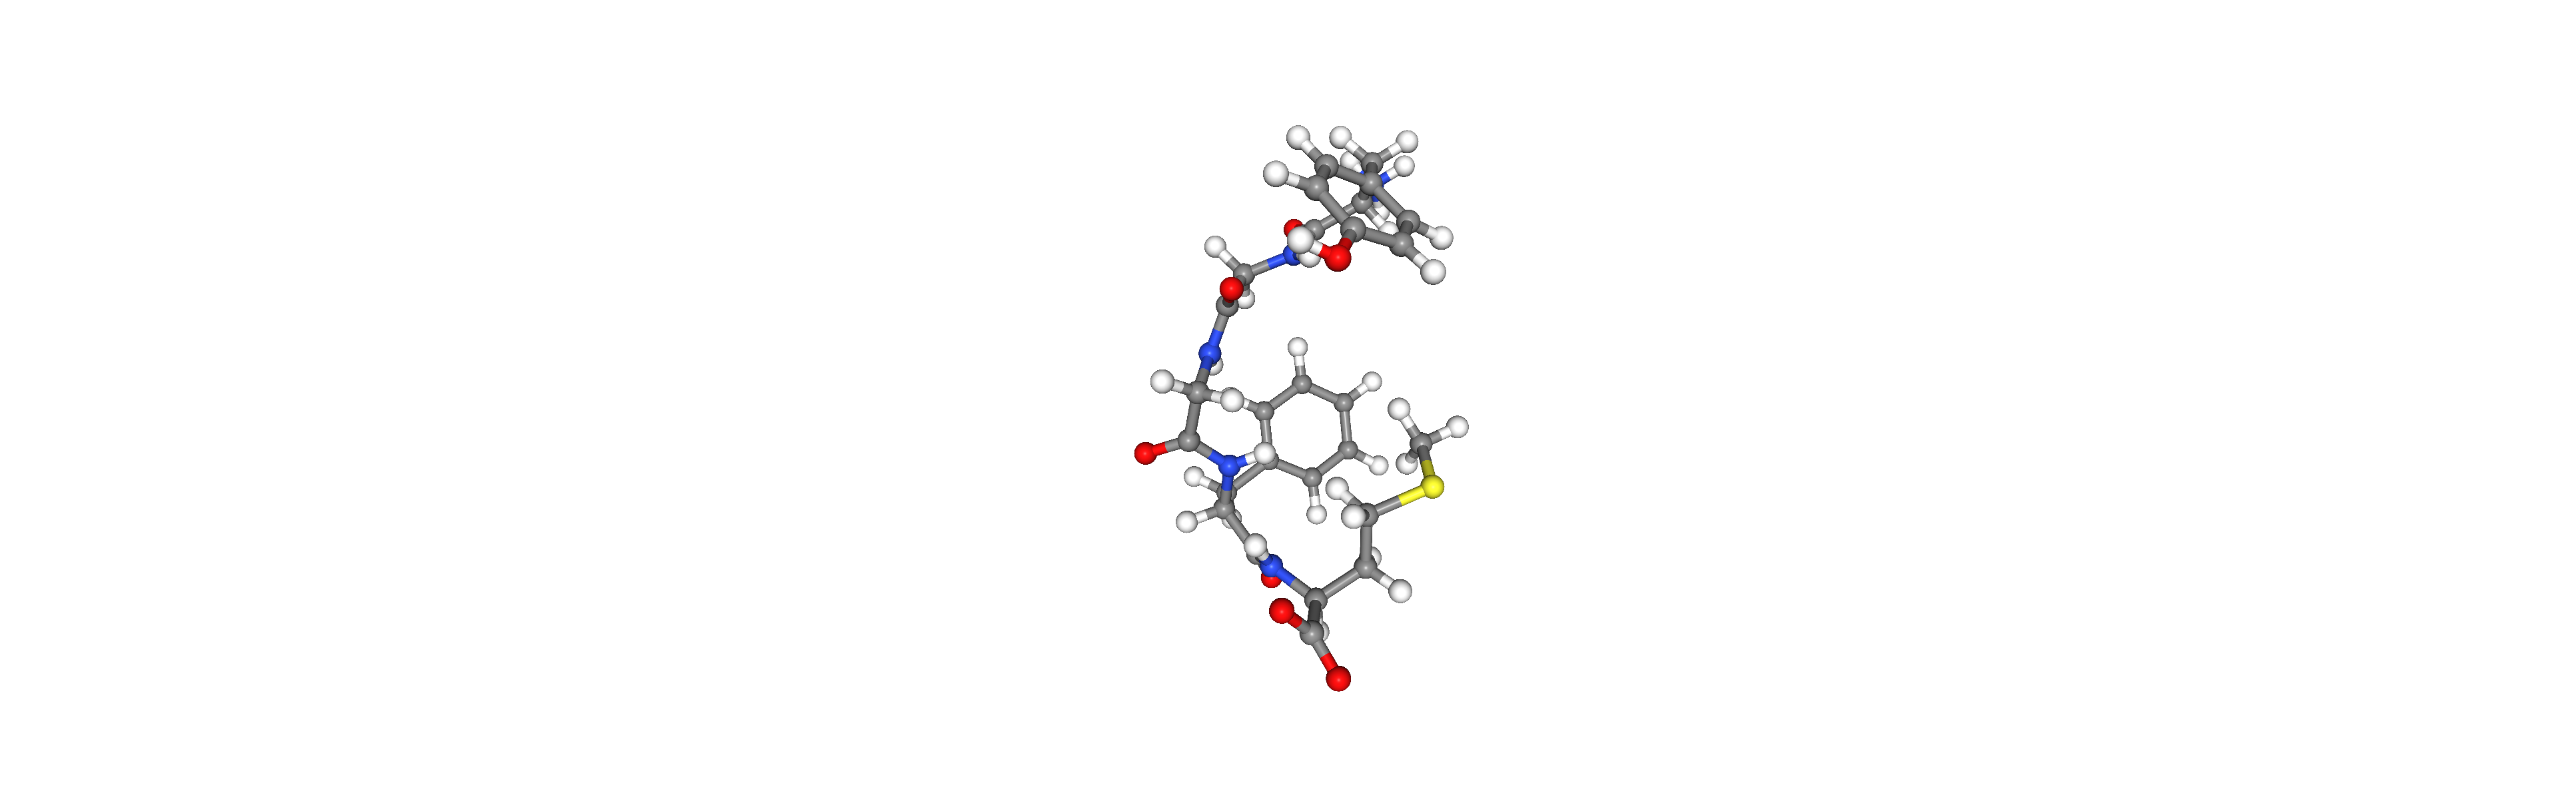

In [48]:
view_traj._display_image() # Para que la imagen pueda ser mostrada en la versión del notebook de GitHub

## Mínimo RMSD del péptido en función del tiempo

La molécula ya fue trasladada y rotada en cada frame buscando el mínimo rmsd de su cadena principal con respecto al frame 0. Podemos calcular ahora el rmsd de la trayectoria que será igual que el mínimo rmsd:

In [49]:
rmsd = md.rmsd(traj_md, traj_md, atom_indices=traj_md.topology.select("backbone"))

Y lo representamos frente al tiempo:

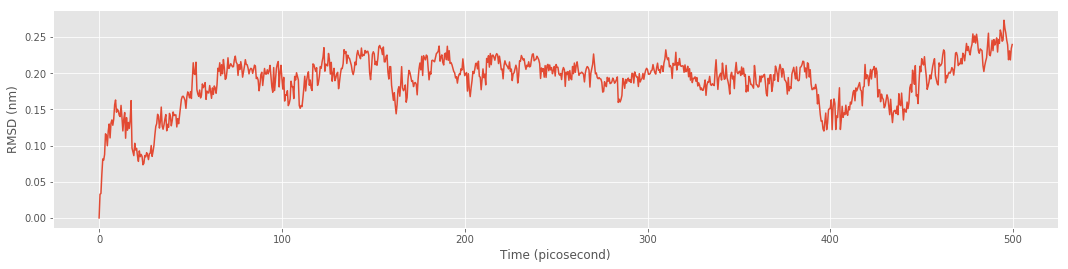

In [50]:
plt.rcParams['figure.figsize'] = 18, 4
plt.plot(traj_md.time*saving_time,rmsd[:])
plt.ylabel('RMSD (nm)')
plt.xlabel('Time ('+str(saving_time.unit)+')')
plt.show()

## Puentes de hidrógeno internos

Calculamos puentes de hidrógeno internos del péptido. Primero, haciendo uso de un método implementado en `mdtraj`, identificamos aquellos puentes de hidrógeno que pueden ser relevantes y que aparecen al menos el 0.1% de la trayectoria

In [51]:
hbonds = md.baker_hubbard(traj_md, freq=0.01, periodic=False)
label = lambda hbond : '%s -- %s' % (traj_md.topology.atom(hbond[0]), traj_md.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))

PHE4-N -- GLY2-O
MET5-N -- GLY2-O
MET5-N -- GLY3-O


Calculamos ahora la serie temporales de algunos de estos puentes de hidrógeno. Para ello usaremos un método implementado en `MDAnalysis`. Lo primero que debemos hacer, con ayuda de `MolModMT`, es convertir el objeto trayectoria de `mdtraj` al objeto nativo de `MDAnalysis` que codifica el sistema molecular y la trayectoria.

In [52]:
traj_mdanalysis = molmodmt.load('trajectory.dcd','mdanalysis',topology='metenkephalin_solvated.pdb')

/home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:72: UserWarning: Failed to guess the mass for the following atom types: Cl
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [53]:
traj_mdanalysis

<Universe with 5535 atoms>

In [54]:
traj_mdanalysis.trajectory

<DCDReader trajectory.dcd with 1000 frames of 5535 atoms>

Hacemos uso ahora de la función implementada en `MDAnalysis` para el cálculo de puentes de hidrógeno. Calcularemos los puentes entre los residuos TYR1 y MET5:

In [55]:
from MDAnalysis.analysis.hbonds import HydrogenBondAnalysis as hbond_analysis

In [56]:
hbonds = hbond_analysis(traj_mdanalysis, 'resname TYR and resid 1', 'resname MET and resid 5',
                        distance=3.0, angle=120.0, filter_first=True)

Antes de ejecutar el cálculo de puentes de hidrógeno, podemos ver los nombres de los átomos que MDAnálysis considera aceptores o dadores:

In [57]:
print(hbonds.donors)

('OW', 'OH2', 'SG', 'ND2', 'ND1', 'OG', 'NE2', 'N', 'NH1', 'OG1', 'NE', 'NE1', 'NH2', 'NZ', 'OH')


In [58]:
print(hbonds.acceptors)

('OW', 'SD', 'OC2', 'NE2', 'OE1', 'OG1', 'OH', 'O', 'SG', 'OE2', 'OD2', 'OH2', 'OC1', 'ND1', 'OG', 'OD1')


El nombre 'OXT' no está considerado por defecto en su lista de aceptores, pero lo podemos incluir nosotros para que lo considere en el cálculo.

In [59]:
hbonds.acceptors=hbonds.acceptors + ("OXT",)

In [60]:
print(hbonds.acceptors)

('OW', 'SD', 'OC2', 'NE2', 'OE1', 'OG1', 'OH', 'O', 'SG', 'OE2', 'OD2', 'OH2', 'OC1', 'ND1', 'OG', 'OD1', 'OXT')


Ya podemos correr el análisis esperando el cálculo de cuando los puentes de hidrógeno TYR1-OH -- MET5-O
y TYR1-OH -- MET5-OXT están formados según el criterio elegido para los criterios: distancia entre aceptor e hidrógeno unido a dador, y ángulo entre dador, hidrógeno unido a dador y aceptor.

In [61]:
hbonds.run(step=1)

In [62]:
hbonds.generate_table()

In [63]:
print(hbonds.table)

[( 43.00000013, 22, 63, 'TYR', 1, 'HH', 'MET', 5, 'SD', 2.4405467 , 142.79804125)
 ( 47.50000014, 22, 63, 'TYR', 1, 'HH', 'MET', 5, 'SD', 2.69294033, 137.79165663)
 (415.50000124, 14, 63, 'TYR', 1, 'H3', 'MET', 5, 'SD', 2.49129872, 140.16974318)
 ...
 (465.00000139, 14, 63, 'TYR', 1, 'H3', 'MET', 5, 'SD', 2.16008392, 152.44029006)
 (465.50000139, 14, 63, 'TYR', 1, 'H3', 'MET', 5, 'SD', 2.79712181, 137.78219454)
 (466.00000139, 14, 63, 'TYR', 1, 'H3', 'MET', 5, 'SD', 2.88584297, 124.9388748 )]


Representemos gráficamente la presencia en función del tiempo de cada uno de estos dos puentes de hidrógeno:

In [64]:
lista_hbonds=hbonds.timesteps_by_type()

In [65]:
lista_hbonds.dtype

dtype((numpy.record, [('donor_index', '<i8'), ('acceptor_index', '<i8'), ('donor_resnm', '<U4'), ('donor_resid', '<i8'), ('donor_heavy_atom', '<U4'), ('donor_atom', '<U4'), ('acceptor_resnm', '<U4'), ('acceptor_resid', '<i8'), ('acceptor_atom', '<U4'), ('time', '<f8')]))

In [66]:
tiempos_hbond_O = []
tiempos_hbond_OXT = []

for hbond in lista_hbonds:
    if hbond['acceptor_atom']=='O':
        tiempos_hbond_O.append(hbond['time'])
    elif hbond['acceptor_atom']=='OXT':
        tiempos_hbond_OXT.append(hbond['time'])

num_hbonds_O = len(tiempos_hbond_O)
num_hbonds_OXT = len(tiempos_hbond_OXT)

O programado de una manera más compacta:

In [67]:
filtro_O = (lista_hbonds['acceptor_atom']=='O')
filtro_OXT = (lista_hbonds['acceptor_atom']=='OXT')
tiempos_hbond_O   = lista_hbonds[filtro_O]['time']
tiempos_hbond_OXT = lista_hbonds[filtro_OXT]['time']
num_hbonds_O = tiempos_hbond_O.shape[0]
num_hbonds_OXT = tiempos_hbond_OXT.shape[0]

Text(0.5, 0, 'time (ps)')

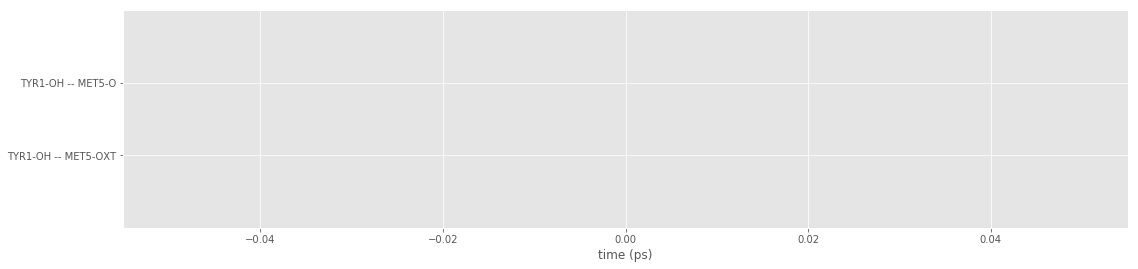

In [68]:
plt.scatter(tiempos_hbond_O,np.ones(tiempos_hbond_O.shape))
plt.scatter(tiempos_hbond_OXT,np.zeros(tiempos_hbond_OXT.shape))
plt.yticks([0,1],['TYR1-OH -- MET5-OXT','TYR1-OH -- MET5-O'])
plt.ylim([-1,2])
plt.xlabel('time (ps)')

## Distancia entre átomos

Por último calcularmos la distancia entre el C-terminal y el N-terminal en función del tiempo. Usamos ahora de nuevo `mdtraj` por tener una función muy cómoda para este propósito:

In [69]:
sel_N_term = molmodmt.select(traj_md, "resid 0 and name N", "mdtraj")
sel_C_term = molmodmt.select(traj_md, "resid 4 and name C", "mdtraj")

In [70]:
print(sel_N_term, sel_C_term)

[0] [59]


In [71]:
pares_de_atomos = [[ii,jj] for ii,jj in zip(sel_N_term, sel_C_term)]

In [72]:
print(pares_de_atomos)

[[0, 59]]


In [73]:
distancia_extremos = md.compute_distances(traj_md,pares_de_atomos)

In [74]:
print("La forma del vector de numpy `distancia_extremos` es:", distancia_extremos.shape)

La forma del vector de numpy `distancia_extremos` es: (1000, 1)


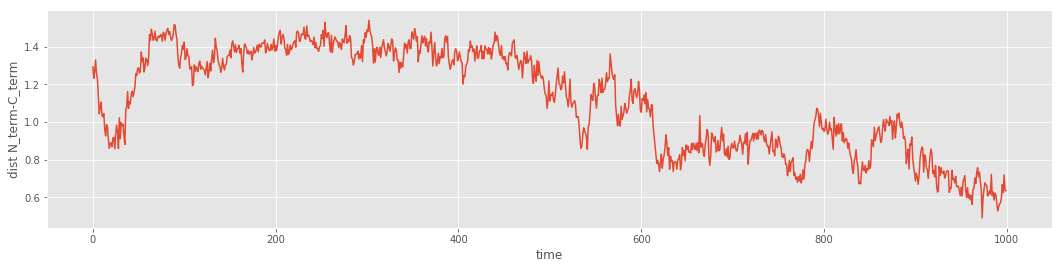

In [75]:
plt.plot(traj_md.time,distancia_extremos[:,0])
plt.xlabel("time")
plt.ylabel("dist N_term-C_term")
plt.show()

Pero no siempre vas a tener a tu disposición en las librerías que conoces la función o método que necesitas. Lo bueno de esta forma de trabajar es que tienes toda la información y apoyos auxiliares en forma de funciones externas para implementar el cálculo del observable que deseas. Supongamos que, dado que la trayectoria del péptido ha sido solapada minimizando el rmsd de la cadena principal, hagamos nosotros mismos la función del cálculo de la distancia en los átomos N y C terminal:

In [76]:
átomo_N_term = molmodmt.select(traj_md, "resid 0 and name N", "mdtraj")[0]
átomo_C_term = molmodmt.select(traj_md, "resid 4 and name C", "mdtraj")[0]

In [77]:
trayectoria_N_term = traj_md.xyz[:,átomo_N_term]
trayectoria_C_term = traj_md.xyz[:,átomo_C_term]

In [78]:
trayectoria_vector_distancia=trayectoria_C_term-trayectoria_N_term

In [79]:
mi_distancia_extremos = np.sqrt(trayectoria_vector_distancia[:,0]**2 + 
                                trayectoria_vector_distancia[:,1]**2 + 
                                trayectoria_vector_distancia[:,2]**2)

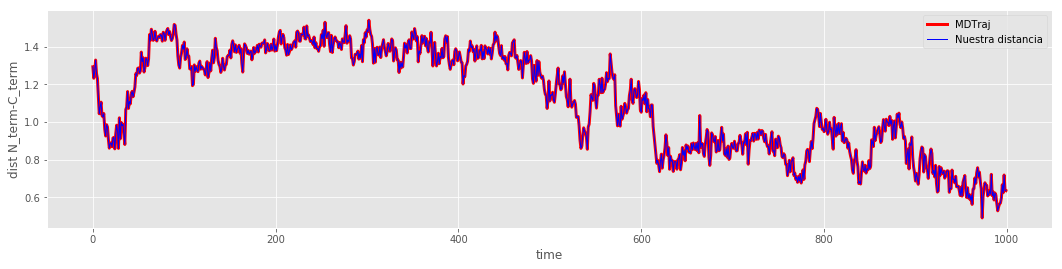

In [80]:
plt.plot(traj_md.time,distancia_extremos[:,0],'r',linewidth=3,label='MDTraj')
plt.plot(traj_md.time,mi_distancia_extremos,'b',linewidth=1,label='Nuestra distancia')
plt.xlabel("time")
plt.ylabel("dist N_term-C_term")
plt.legend()
plt.show()